### Eliminación de sesgos del dataset (segunda aproximación)
En la primera aproximación obtuvimos buenos resultados en el balance de las edades pero no así en el balance de géneros y razas. En esta segunda aproximación cambiaremos el orden de prioridades a la hora de balancear, priorizando primero la raza, luego el género y por último la edad.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random as rnd
import copy

De igual manera cargamos los datos del dataset original y creamos los conjuntos de datos que formaran el dataframe

In [2]:
origin_path = '../datasets/UTKFace_origin/'
debiased_path = '../datasets/UTKFace_debiased/'
images = os.listdir(origin_path)
count = 0
conflicted = []
for i in images:
    splited_i = i.split('_')
    if len(splited_i) < 4:
        count += 1
        print(i)
        conflicted.append(i)
        
for i in conflicted:
    images.remove(i)

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg


In [3]:
ages = []
genders = []
races = []
for i in images:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    races.append(int(split[2]))

In [4]:
pd_images = pd.Series(list(images), name = 'Images')
pd_ages = pd.Series(list(ages), name = 'Ages')
pd_genders = pd.Series(list(genders), name = 'Genders')
pd_races = pd.Series(list(races), name = 'Races')

df = pd.concat([pd_images, pd_ages, pd_genders, pd_races], axis=1)
df

,Images,Ages,Genders,Races
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0
...,...,...,...,...
23700,9_1_3_20161220222856346.jpg.chip.jpg,9,1,3
23701,9_1_3_20170104222949455.jpg.chip.jpg,9,1,3
23702,9_1_4_20170103200637399.jpg.chip.jpg,9,1,4
23703,9_1_4_20170103200814791.jpg.chip.jpg,9,1,4


En este caso utilizaremos una estructura de datos distinta para el facil acceso a los datos segun las prioridades. Primero tendremos la matriz "races_genders" donde en la fila i (i-ésima raza) y columna j (j-ésimo género) tenderemos la cantidad de imágenes que pertenecen a las correspondientes razas-géneros. Luego un diccionario donde las tuplas (género,raza) son las llaves y devuelve una lista de tamaño cantidad de edades del dataset con la cantidad de imágenes que tienen la edad = posición i. Por último un diccionario de triplas (race,gender,age) a la lista de imágenes que cumplen con las tres características.

In [23]:
races_genders = np.array([[0]*len(df["Genders"].value_counts())] * len(df["Races"].value_counts()))
racesGenders_age = {}
images_browser = {}

for i in range(len(images)):
    age = ages[i]
    gender = genders[i]
    race = races[i]
    image = images[i]
    
    races_genders[race][gender] += 1
    if (race,gender) not in racesGenders_age:
        racesGenders_age[(race,gender)] = [0]*pd_ages.max()
    racesGenders_age[(race,gender)][age-1] += 1
    if (race,gender,age) not in images_browser:
        images_browser[(race,gender,age)] = []
    images_browser[(race,gender,age)].append(image)
    
racesGenders_age

{(0, 0): [143,
  55,
  41,
  50,
  28,
  14,
  39,
  45,
  114,
  67,
  21,
  25,
  30,
  41,
  58,
  109,
  40,
  32,
  17,
  46,
  32,
  44,
  39,
  69,
  110,
  268,
  93,
  136,
  97,
  145,
  55,
  114,
  26,
  89,
  233,
  107,
  70,
  61,
  69,
  186,
  38,
  86,
  54,
  19,
  146,
  39,
  67,
  56,
  44,
  131,
  58,
  101,
  97,
  145,
  113,
  76,
  43,
  136,
  43,
  89,
  55,
  45,
  53,
  23,
  99,
  19,
  42,
  46,
  12,
  66,
  13,
  27,
  22,
  16,
  65,
  15,
  8,
  30,
  8,
  58,
  6,
  17,
  6,
  1,
  30,
  7,
  3,
  6,
  2,
  31,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0],
 (0, 1): [144,
  39,
  74,
  57,
  47,
  40,
  32,
  127,
  17,
  39,
  28,
  53,
  30,
  56,
  43,
  73,
  37,
  116,
  28,
  68,
  46,
  46,
  77,
  133,
  132,
  261,
  78,
  118,
  93,
  134,
  46,
  123,
  38,
  58,
  143,
  72,
  53,
  54,
  59,
  87,
  25,
  44,
  24,
  13,
  61,
  24,
  26,
  29,
  47,
 

In [24]:
def get_minority_age(minority_race, minority_gender):
    aux = [10000 if age_count == 0 else age_count for age_count in racesGenders_age[(minority_race, minority_gender)]]
    return np.argmin(aux) + 1
    

def get_majority_age(majority_race, majority_gender):
    return np.argmax(racesGenders_age[(majority_race, majority_gender)]) + 1

Una vez que las diferentes estructuras de datos contienen la información de todas las imágenes el procedimiento es el siguiente:

$\bullet$ De la matriz races_genders obtenemos cuáles son la raza y género menor/mayor cantidad de datos.

$\bullet$ Luego dado el par obtenido se busca la edad con la mínima/maxima cantidad de datos.

$\bullet$ Una vez que tenoemos la tripla (raza,género,edad) seleccionamos una imagen aleatoria de la lista y se genera/elimina a partir de ella. 

In [25]:
epsilon = 500
count_generated_images = 0
modified_images_browser = copy.deepcopy(images_browser)



#Getting minority and majority race
rows_sum = np.sum(races_genders, axis=1)
minority_race = np.argmin(rows_sum)
majority_race = np.argmax(rows_sum)

while rows_sum.max() - rows_sum.min() > epsilon:
    

    minority_gender = np.argmin(races_genders[minority_race])
    majority_gender = np.argmax(races_genders[majority_race])

    minority_age = get_minority_age(minority_race, minority_gender)
    majority_age = get_majority_age(majority_race, majority_gender)
    
    #Generate an image with the selected tags
    aux_images = images_browser[(minority_race, minority_gender, minority_age )]
    index = rnd.randint(0, len(aux_images)-1)
    img_name = augment_image(aux_images[index], origin_path, debiased_path, count_generated_images)
    races_genders[minority_race][minority_gender] += 1
    racesGenders_age[(minority_race,minority_gender)][minority_age-1] += 1
    modified_images_browser[(minority_race, minority_gender, minority_age )].append(img_name)
    count_generated_images += 1
    
    #Delete an image with the selected tags
    aux_images = images_browser[(majority_race, majority_gender, majority_age )]
    index = rnd.randint(0, len(aux_images)-1)
    aux_images.pop(index)
    races_genders[majority_race][majority_gender] -= 1
    racesGenders_age[(majority_race,majority_gender)][majority_age-1] -= 1
    
    
    rows_sum = np.sum(races_genders, axis=1)
    minority_race = np.argmin(rows_sum)
    majority_race = np.argmax(rows_sum)

races_genders

array([[2570, 2571],
       [2321, 2320],
       [2321, 2320],
       [2321, 2320],
       [2321, 2320]])

Una vez terminado el proceso de depuración copiamos los elementos del dataset resultante a la carpeta de destino.

In [27]:
for images_list in images_browser.values():
    for image in images_list:
        copy2(origin_path + image, debiased_path)

Repetimos el proceso de cargar los datos para analizar el dataset resultante.

In [28]:
origin_path = '../datasets/UTKFace_debiased/'
images = os.listdir(origin_path)
count = 0
conflicted = []
for i in images:
    splited_i = i.split('_')
    if len(splited_i) < 4:
        count += 1
        print(i)
        conflicted.append(i)
        
for i in conflicted:
    images.remove(i)

ages = []
genders = []
races = []
for i in images:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    races.append(int(split[2]))
    
pd_images = pd.Series(list(images), name = 'Images')
pd_ages = pd.Series(list(ages), name = 'Ages')
pd_genders = pd.Series(list(genders), name = 'Genders')
pd_races = pd.Series(list(races), name = 'Races')

df = pd.concat([pd_images, pd_ages, pd_genders, pd_races], axis=1)
df

,Images,Ages,Genders,Races
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0
...,...,...,...,...
23700,9_1_4_20170103213057382.jpg.chip.jpg2946.jpg,9,1,4
23701,9_1_4_20170103213057382.jpg.chip.jpg315.jpg,9,1,4
23702,9_1_4_20170103213057382.jpg.chip.jpg3258.jpg,9,1,4
23703,9_1_4_20170103213057382.jpg.chip.jpg563.jpg,9,1,4


Luego de graficar el conjunto de datos nos percatamos que logramos un buen balance de raza y género, no así con la edad ya que la dejamos como última prioridad.

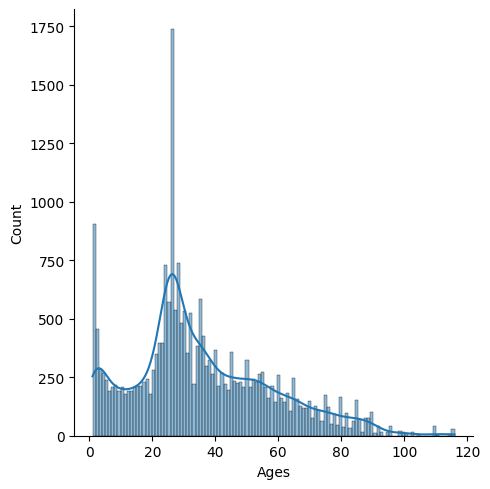

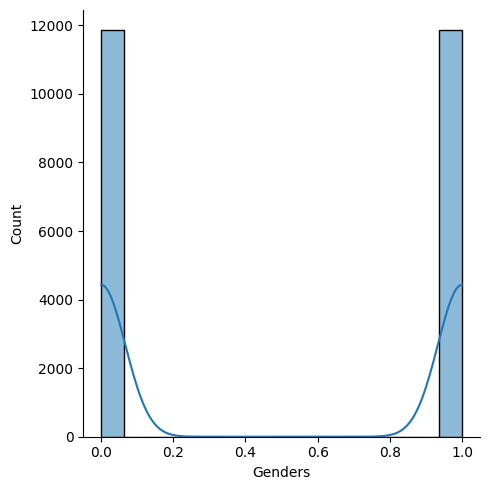

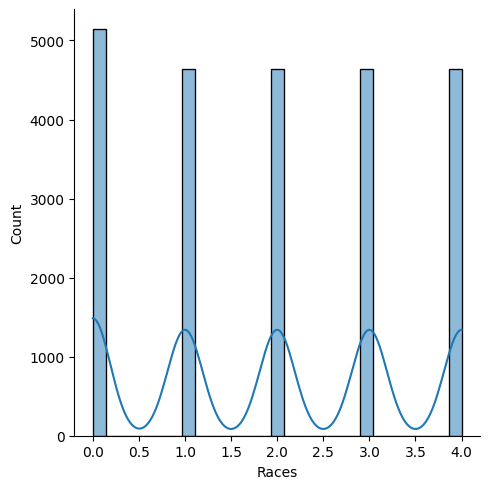

In [29]:
sns.displot(df['Ages'],kde=True, bins=116)
sns.displot(df['Genders'],kde=True)
sns.displot(df['Races'],kde=True)